# 1. Import Required Libraries

In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import spacy
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from transformers import BertTokenizer, TFBertModel
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


# 2. Load the Dataset

In [3]:
# Loading the dataset
file_path = 'train.csv'
data = pd.read_csv('/content/train.csv')

# 3. Data Cleaning: Check for Missing Values

In [5]:
# Checking for missing (null) values in the dataset
print("Missing values in the dataset before cleaning:")
print(data.isnull().sum())

Missing values in the dataset before cleaning:
index                    0
beer/ABV                 0
beer/beerId              0
beer/brewerId            0
beer/name                0
beer/style               0
review/appearance        0
review/aroma             0
review/overall           0
review/palate            0
review/taste             0
review/text             10
review/timeStruct        0
review/timeUnix          0
user/ageInSeconds    29644
user/birthdayRaw     29644
user/birthdayUnix    29644
user/gender          22186
user/profileName         5
dtype: int64


# 4. Handling Missing Values
You can choose from different methods to handle missing values. Below are a few options:

**a. Drop Rows with Missing Values (if the number of rows with missing values is small)**

In [6]:
# Dropping rows with any missing values
data = data.dropna()

**b. Fill Missing Values with Mean (for numerical columns)**

In [8]:
data = data.fillna(data.mean(numeric_only=True))

**c. Fill Missing Values for Specific Columns**

In [9]:
# Assuming 'beer/ABV' column has missing values, you can fill it with the mean:
data['beer/ABV'] = data['beer/ABV'].fillna(data['beer/ABV'].mean())


**d. Forward Fill or Backward Fill Missing Values**

In [10]:
# Forward filling missing values
data = data.ffill()

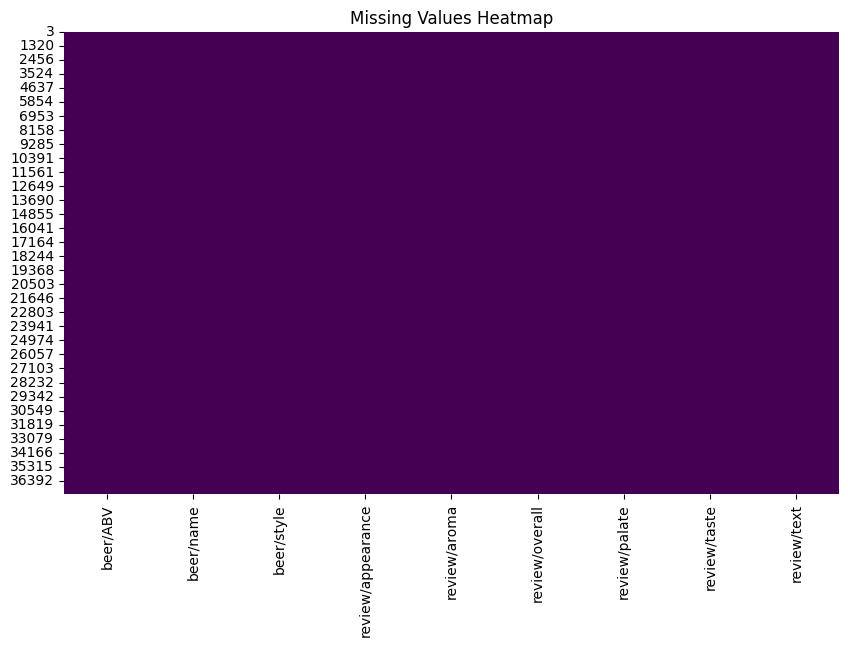

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
# Visualize the missing data using a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(data.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Values Heatmap")
plt.show()

**Data Summary and Visualization**


Data Summary:
          beer/ABV  review/appearance  review/aroma  review/overall  \
count  7709.000000        7709.000000   7709.000000     7709.000000   
mean      7.462990           3.911467      3.896679        3.911337   
std       2.306848           0.591666      0.671773        0.699233   
min       0.500000           1.000000      1.000000        1.000000   
25%       5.500000           3.500000      3.500000        3.500000   
50%       7.000000           4.000000      4.000000        4.000000   
75%       9.400000           4.500000      4.500000        4.500000   
max      39.440000           5.000000      5.000000        5.000000   

       review/palate  review/taste  
count    7709.000000   7709.000000  
mean        3.865936      3.952199  
std         0.668553      0.714148  
min         1.000000      1.000000  
25%         3.500000      3.500000  
50%         4.000000      4.000000  
75%         4.500000      4.500000  
max         5.000000      5.000000  


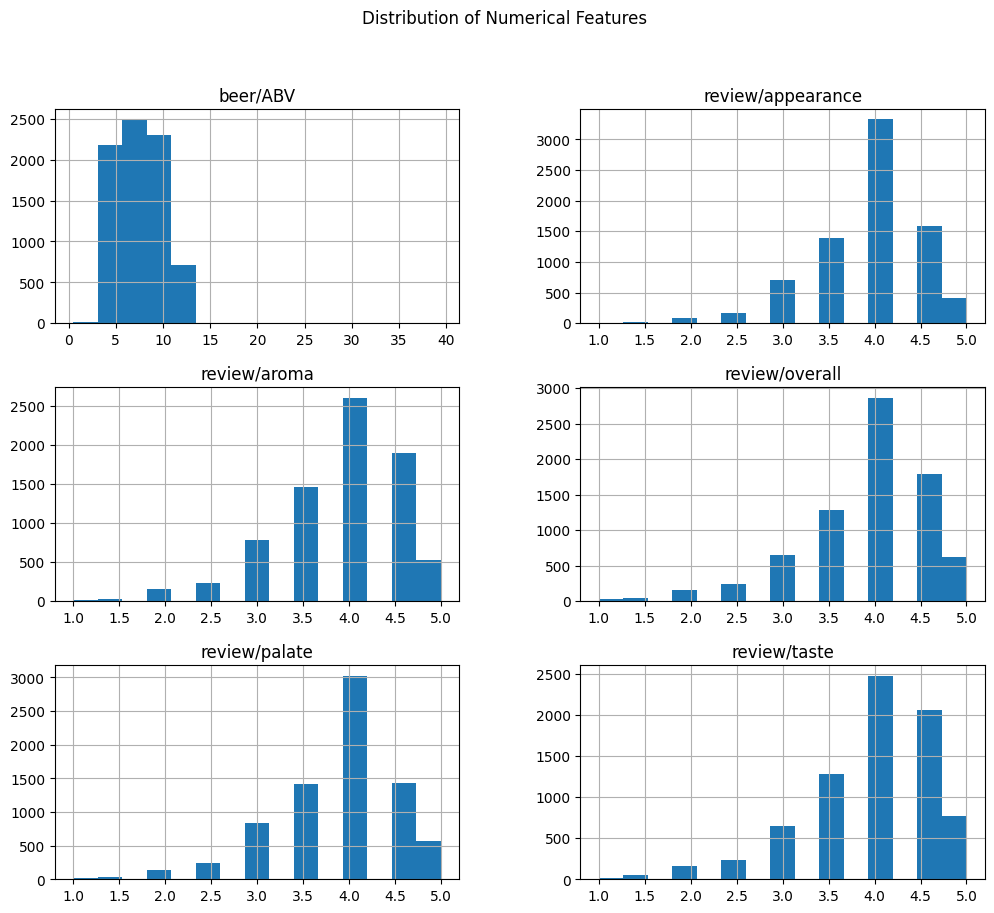

In [29]:
# Display summary statistics of the data
print("\nData Summary:")
print(data.describe())

# Visualize the distribution of numerical columns
data_numeric = data.select_dtypes(include=[np.number])
data_numeric.hist(figsize=(12, 10), bins=15)
plt.suptitle("Distribution of Numerical Features")
plt.show()

**Correlation Heatmap**

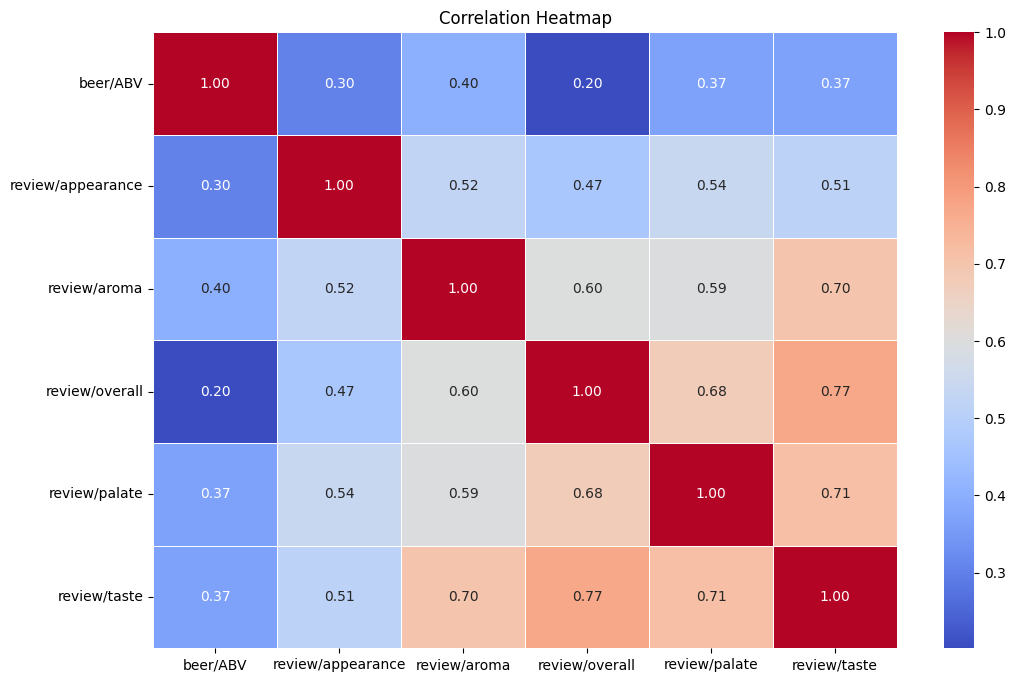

In [30]:
# Compute the correlation matrix
correlation_matrix = data_numeric.corr()

# Plot the heatmap for correlations between numerical features
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()


**Check for Duplicates**

In [31]:
# Check for duplicate rows
duplicates = data.duplicated().sum()

# Display the number of duplicate rows
print(f"\nNumber of Duplicate Rows: {duplicates}")

# Drop duplicate rows if any
data.drop_duplicates(inplace=True)

# Verify if duplicates are removed
print("\nDuplicate Rows After Removal:")
print(data.duplicated().sum())



Number of Duplicate Rows: 0

Duplicate Rows After Removal:
0


# 5. Check for Missing Values Again After Cleaning

In [32]:
# Final check for missing values and summary after cleaning
print("\nFinal Data Summary After Cleaning:")
print(data.isnull().sum())

# Display the cleaned data
data.head()


Final Data Summary After Cleaning:
beer/ABV             0
beer/name            0
beer/style           0
review/appearance    0
review/aroma         0
review/overall       0
review/palate        0
review/taste         0
review/text          0
dtype: int64


,beer/ABV,beer/name,beer/style,review/appearance,review/aroma,review/overall,review/palate,review/taste,review/text
3,4.4,Pilsner Urquell,Czech Pilsener,3.0,3.0,2.5,3.0,3.0,First thing I noticed after pouring from green...
19,7.2,Founders Centennial IPA,American IPA,3.5,3.5,4.0,4.0,3.5,The Centennial IPA pours a nicely carbonated r...
22,5.5,Pumpkin Ale,Pumpkin Ale,3.0,4.0,5.0,4.5,4.5,Pours a murky amber with a nice off-white head...
32,6.0,La Goule,Witbier,3.5,3.5,3.5,4.0,3.0,This one is only found in France where I got i...
39,5.4,Aecht Schlenkerla Rauchbier MÃ¤rzen,Rauchbier,3.5,4.5,3.5,3.5,4.5,Pours a caramel brown color. With a very subtl...


**Correlation Heatmap**

In [ ]:
# Compute the correlation matrix
correlation_matrix = data_numeric.corr()

# Plot the heatmap for correlations between numerical features
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()


# 6. Drop Unimportant Columns

In [12]:
# Dropping unimportant columns
columns_to_drop = ['beer/beerId', 'beer/brewerId', 'review/timeStruct', 'review/timeUnix',
                   'user/ageInSeconds', 'user/birthdayRaw', 'user/birthdayUnix',
                   'user/gender', 'user/profileName', 'index']
data = data.drop(columns=columns_to_drop, axis=1)


# 7. Prepare Data for Feature Engineering

In [13]:
# Splitting the data into features (X) and target variable (Y)
X = data.drop(columns='review/overall', axis=1)
Y = data['review/overall']

# 8. Splitting Data into Train and Test Sets

In [14]:
# Splitting the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# 9. Text Preprocessing with SpaCy

In [15]:
# Loading the spaCy English model
nlp = spacy.load('en_core_web_sm')

# Function for preprocessing the text using spaCy
def preprocess_text(text):
    doc = nlp(text)
    tokens = [token.text.lower() for token in doc if not token.is_punct and not token.is_stop]
    preprocessed_text = ' '.join(tokens)
    return preprocessed_text

# Preprocessing text columns (beer/name, beer/style, and review/text)
text_columns = ['beer/name', 'beer/style', 'review/text']


# 10. Tokenize and Vectorize Text using BERT

In [16]:
# Loading pre-trained BERT tokenizer and model from Hugging face library
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = TFBertModel.from_pretrained('bert-base-uncased')

# Function for tokenizing and converting texts to BERT embeddings
def tokenize_and_vectorize(text):
    tokens = tokenizer.encode_plus(text, add_special_tokens=True, return_tensors='tf', padding=True, truncation=True)
    outputs = model(tokens)
    return tf.reduce_mean(outputs.last_hidden_state, axis=1).numpy()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

# 11. Apply Preprocessing and Vectorization to Training Data

In [17]:
# Applying preprocessing and BERT vectorization to training data
all_texts_name = []
all_texts_style = []
all_texts_review = []

for item in text_columns:
    if item == 'beer/name':
        all_texts_name.extend(preprocess_text(text) for text in X_train[item].astype(str))
    elif item == 'beer/style':
        all_texts_style.extend(preprocess_text(text) for text in X_train[item].astype(str))
    elif item == 'review/text':
        all_texts_review.extend(preprocess_text(text) for text in X_train[item].astype(str))

# Tokenizing and vectorizing using BERT
X_train_bert_name = np.array([tokenize_and_vectorize(text) for text in all_texts_name])
X_train_bert_style = np.array([tokenize_and_vectorize(text) for text in all_texts_style])
X_train_bert_review = np.array([tokenize_and_vectorize(text) for text in all_texts_review])


# 12. Apply Preprocessing and Vectorization to Test Data

In [18]:
# Applying preprocessing and BERT vectorization to test data
all_texts_name_test = []
all_texts_style_test = []
all_texts_review_test = []

for item in text_columns:
    if item == 'beer/name':
        all_texts_name_test.extend(preprocess_text(text) for text in X_test[item].astype(str))
    elif item == 'beer/style':
        all_texts_style_test.extend(preprocess_text(text) for text in X_test[item].astype(str))
    elif item == 'review/text':
        all_texts_review_test.extend(preprocess_text(text) for text in X_test[item].astype(str))

# Tokenizing and vectorizing using BERT
X_test_bert_name = np.array([tokenize_and_vectorize(text) for text in all_texts_name_test])
X_test_bert_style = np.array([tokenize_and_vectorize(text) for text in all_texts_style_test])
X_test_bert_review = np.array([tokenize_and_vectorize(text) for text in all_texts_review_test])


# 13. Flatten the BERT Embeddings

In [19]:
# Flattening the BERT embeddings for training data
X_train_bert_name_flat = X_train_bert_name.reshape(X_train_bert_name.shape[0], -1)
X_train_bert_style_flat = X_train_bert_style.reshape(X_train_bert_style.shape[0], -1)
X_train_bert_review_flat = X_train_bert_review.reshape(X_train_bert_review.shape[0], -1)

# Flattening the BERT embeddings for test data
X_test_bert_name_flat = X_test_bert_name.reshape(X_test_bert_name.shape[0], -1)
X_test_bert_style_flat = X_test_bert_style.reshape(X_test_bert_style.shape[0], -1)
X_test_bert_review_flat = X_test_bert_review.reshape(X_test_bert_review.shape[0], -1)


# 14. Separate Numerical Features and Concatenate with BERT Features

In [20]:
# Extracting numerical features from the training and test sets
dx_train = X_train.drop(columns=text_columns, axis=1)
dx_test = X_test.drop(columns=text_columns, axis=1)

# Concatenating the BERT embeddings with the numerical features
X_train_combined = np.concatenate([X_train_bert_name_flat, X_train_bert_style_flat, X_train_bert_review_flat, dx_train.values], axis=1)
X_test_combined = np.concatenate([X_test_bert_name_flat, X_test_bert_style_flat, X_test_bert_review_flat, dx_test.values], axis=1)


# 15. Modeling: Hyperparameter Tuning for Random Forest and SVR

In [21]:
# Defining the parameter grid for Random Forest Regressor
param_grid_rf = {
    'randomforestregressor__n_estimators': [50, 100, 150],
    'randomforestregressor__max_depth': [None, 10, 20],
    'randomforestregressor__min_samples_split': [2, 5, 10],
    'randomforestregressor__min_samples_leaf': [1, 2, 4]
}

# Defining the parameter grid for Support Vector Regressor
param_grid_svr = {
    'svr__C': [0.1, 1, 10],
    'svr__epsilon': [0.1, 0.2, 0.5],
    'svr__kernel': ['linear', 'rbf']
}


# 16. Model Training and Grid Search

In [24]:
# Creating a pipeline for Random Forest Regressor
rf_pipe = make_pipeline(RandomForestRegressor(random_state=42))

# Creating a pipeline for Support Vector Regressor with standardization
svr_pipe = make_pipeline(StandardScaler(), SVR())

# Creating GridSearchCV objects for both models
grid_search_rf = GridSearchCV(rf_pipe, param_grid_rf, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_svr = GridSearchCV(svr_pipe, param_grid_svr, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

In [34]:
# Identify non-numeric columns
non_numeric_columns = X_train.select_dtypes(include=['object']).columns
print("Non-numeric columns:", non_numeric_columns)


Non-numeric columns: Index(['beer/name', 'beer/style', 'review/text'], dtype='object')


In [35]:
X_train = X_train.drop('beer/name', axis=1)
X_test = X_test.drop('beer/name', axis=1)

In [38]:
print(X_train.columns)


Index(['beer/ABV', 'beer/style', 'review/appearance', 'review/aroma',
       'review/palate', 'review/taste', 'review/text'],
      dtype='object')


In [39]:
print([col for col in X_train.columns if 'beer' in col])


['beer/ABV', 'beer/style']


In [40]:
print(X_train.head())
print(X_test.head())


       beer/ABV                        beer/style  review/appearance  \
9272        6.5            Fruit / Vegetable Beer                3.0   
3756        8.3  American Double / Imperial Stout                4.5   
1611        8.5            Scotch Ale / Wee Heavy                4.0   
28420       6.0                    American Stout                4.0   
7646        5.5           American Pale Ale (APA)                4.0   

       review/aroma  review/palate  review/taste  \
9272            4.0            3.5           3.0   
3756            5.0            4.5           4.5   
1611            4.0            4.0           4.0   
28420           3.5            3.0           3.0   
7646            3.5            4.0           4.5   

                                             review/text  
9272   Poured a fine sized head. Color is a cloudy or...  
3756   I enjoyed this much more than the KBS but it's...  
1611   A - Dark brown... Slight head comes and goes q...  
28420  This beer p

In [50]:
# Define the parameter grids
param_grid_rf = {
    'randomforestregressor__n_estimators': [100, 200, 300],
    'randomforestregressor__max_depth': [None, 10, 20],
    'randomforestregressor__min_samples_split': [2, 5, 10]
}

param_grid_svr = {
    'svr__C': [0.1, 1, 10],
    'svr__gamma': ['scale', 'auto'],
    'svr__kernel': ['linear', 'rbf']
}

# Creating a pipeline for Random Forest Regressor
rf_pipe = make_pipeline(RandomForestRegressor(random_state=42))

# Creating a pipeline for Support Vector Regressor with standardization
svr_pipe = make_pipeline(StandardScaler(), SVR())

# Creating GridSearchCV objects for both models
grid_search_rf = GridSearchCV(rf_pipe, param_grid_rf, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_svr = GridSearchCV(svr_pipe, param_grid_svr, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)